<a href="https://colab.research.google.com/github/Chenzhang0329/StockPrice-Hybrid-Model-/blob/main/Final_Assignment_Main_Good_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Forecasting with a Hybrid Deep Learning Model

# 1.0 Introduction

#2.0 Data Collection and Preprocessing


##2.1 Imports and Configurations

In [1]:
#Import necessary libraries 
import pandas as pd
!pip install yfinance
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from time import time
from google.colab import files
import yfinance as yf
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns
!pip install transformers
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
import multiprocessing as mp
import datetime as dt
from multiprocessing import Process



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 92.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 22.5 MB/s eta 0:00:00


In [2]:
#configure sentiment analysis pipeline
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
nlp = pipeline("sentiment-analysis", model = finbert, tokenizer = tokenizer)
sentiment_dict = {'Negative':-1, 'Neutral':0, 'Positive': 1}
ticker_list = ['MSFT','GOOG', 'AMZN','TSLA','NFLX']
#clone git repo into workspace
!git clone https://github.com/Chenzhang0329/StockPrice-Hybrid-Model-.git

Cloning into 'StockPrice-Hybrid-Model-'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 251 (delta 8), reused 0 (delta 0), pack-reused 230
Receiving objects: 100% (251/251), 7.34 MiB | 9.66 MiB/s, done.
Resolving deltas: 100% (119/119), done.


## 2.2 Setup of Data Collection Functions

In [3]:
# Retrieve financial info from active directory and feature engineer to scale the outcomes to the value of the mean sentiment scores *  count^2
from sklearn.preprocessing import MinMaxScaler
def pull_news(ticker):
    path = '/content/StockPrice-Hybrid-Model-/News Data/'+ticker+'_news.csv'
    news_df = pd.read_csv(path)
    news_list = news_df['headline'].to_list()
    print('success1')
    result = nlp(news_list)
    print('success2')
    result = pd.DataFrame(result)
    news_df["sentiment"] = [sentiment_dict[k]for k in result['label']]  
    news_df['date'] = pd.to_datetime(news_df['date'], format = '%d-%m-%Y')
    sentiment = pd.DataFrame()
    sentiment['mean'] = news_df.groupby(by="date")["sentiment"].mean()
    sentiment['count']= news_df.groupby(by='date')['sentiment'].count()
    sentiment['score'] = sentiment['mean'] * (sentiment['count']**2)
    sentiment = sentiment.fillna(0)
    scaler1 = MinMaxScaler()
    sentiment['score'] = scaler1.fit_transform(sentiment[['score']])
    path3 = ticker+'_sentimentscore.csv'
    sentiment.to_csv(path3)  

#retrieve financial information using yfinance
def get_financials(ticker, start):
    time_delt = dt.timedelta(days = 150)
    start_day = start - time_delt
    data = yf.download(str(ticker), start_day)
    data['ticker'] = ticker
    data = data.reset_index()
    print('success!')
    return data

#Caclulate Exponential moving average
def EWMA(data, ndays): 
    EMA = pd.Series(data['close'].ewm(span = ndays, min_periods = ndays - 1).mean(), 
                 name = 'EWMA_' + str(ndays)) 
    data = data.join(EMA) 
    return data

# Calculate Relative Strength Index
def rsi(close, periods = 14):
    
    close_delta = close.diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

# Calculate Bollinger Bands
def BBANDS(data, window):
    MA = data.close.rolling(window).mean()
    SD = data.close.rolling(window).std()
    data['MiddleBand'] = MA
    data['UpperBand'] = MA + (2 * SD) 
    data['LowerBand'] = MA - (2 * SD)
    return data

# Rolling averages for 10,20,50, and 100 days  feature engineering
def prep_financials(df):
    df = pd.DataFrame(df)
    df.set_index('date')
    df['target'] = (df['close'])
    df['10mda'] = df['close'].rolling(10).mean()
    df['20mda'] = df['close'].rolling(20).mean()
    df['50mda'] = df['close'].rolling(50).mean()
    df['100mda'] = df['close'].rolling(100).mean()
    #df['target'] = [1 if df['pct_change'].loc[i] >0.005 else 0 for i in df.index]
    df = EWMA(df, 20)
    df = EWMA(df, 50) 
    df = EWMA(df, 100)
    df['rsi'] = rsi(df['close'])
    df = BBANDS(df, 20)
    #df.drop(['pct_change'], axis=1, inplace=True)
    df.reset_index()
    return df

In [ ]:
#parallel process to calculate all sentiment scores and process sentiment data into csv files
import datetime as dt
if __name__ == "__main__":
    ticker_list = ['MSFT','GOOG', 'AMZN','TSLA','NFLX']
    processes = []
    proc = Process(target=pull_news)
    processes.append(proc)
    proc.start()

    for tick in ticker_list:
        proc = Process(target =pull_news, args=(tick,))
        processes.append(proc)
        proc.start()
    
    for proc in processes:
        proc.join()


Process Process-1:
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
TypeError: pull_news() missing 1 required positional argument: 'ticker'


success1success1

success1
success1
success1
success2
success2
success2
success2
success2


In [ ]:
#Complete financial info retrieval
finance_dfs = []
for tick in ticker_list:
    data = get_financials(tick, dt.date(2018,1, 1))
    data.rename(columns = {'Date':'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close','Adj Close': 'adj_close', 'Volume':'volume'}, inplace = True)
    print(data.info())
    prepped = prep_financials(data)
    finance_dfs.append(prepped)

#read finance data to csv
full_finance = pd.concat(finance_dfs)
full_finance.to_csv('finance.csv', index = False)

#  3.0 Exploratory Data Analysis(EDA) and Data Cleaning
All data collection and initial prep is completed at this point.

In [5]:
#retrieve sentiment scores and create dataframes with only score and date columns
sentiment_dfs = []
for i in ticker_list:
  data = pd.read_csv('/content/StockPrice-Hybrid-Model-/Sentiment Score/'+i+'_sentimentscore.csv')
  data['date'] = pd.to_datetime(data['date'])
  df = data[['date','score']]
  sentiment_dfs.append(df)
#Check distribution of sentiment dataframe
print(sentiment_dfs[1].describe())

             score
count  1410.000000
mean      0.347804
std       0.046656
min       0.000000
25%       0.343666
50%       0.345013
75%       0.349057
max       1.000000


## 3.1 Create Final Dataframes to Include Both Sentiment Data and Financial Data 

In [6]:
financials = pd.read_csv('finance.csv')
#function to separate dataframe by company
def separate_companies(ticker, df):
    dataframe = df[df['ticker']==ticker]
    return dataframe

#separate dataframes for each company and add new features
df_list = []
for tick in ticker_list:
    data = separate_companies(tick, financials)
    data.reset_index()
    data['date'] = pd.to_datetime(data['date'])
    df_list.append(data)


goog = df_list[1].set_index('date').join(sentiment_dfs[1].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[1].mean())
msft = df_list[0].set_index('date').join(sentiment_dfs[0].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[0].mean())
amzn = df_list[2].set_index('date').join(sentiment_dfs[2].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[2].mean())
tesla = df_list[3].set_index('date').join(sentiment_dfs[3].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[3].mean())
nflx = df_list[4].set_index('date').join(sentiment_dfs[4].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[4].mean())

frames = [goog, msft, amzn, tesla, nflx]


<ipython-input-6-82c985f0176a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
<ipython-input-6-82c985f0176a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
<ipython-input-6-82c985f0176a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

## 3.2 EDA to Explore Change in Stock Prices and Daily Headlines

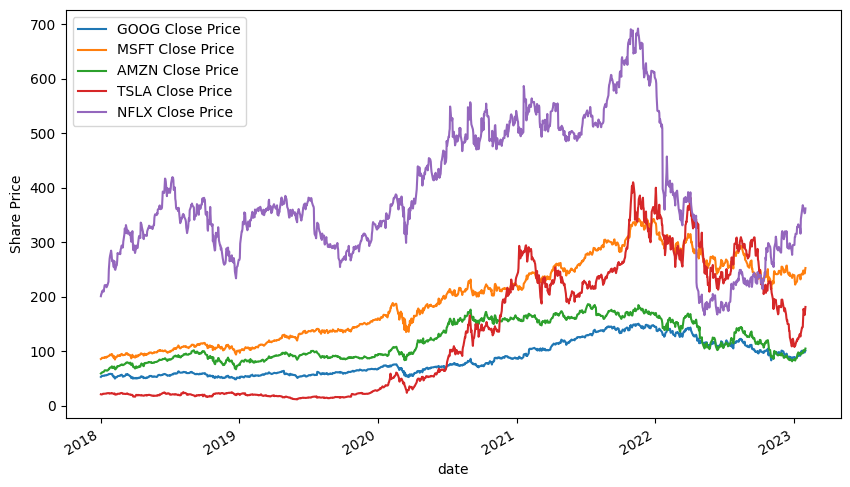

KeyError: ignored

In [7]:
#EDA and summary stats for compiled datasets
ticker_list = ['GOOG', 'MSFT','AMZN','TSLA','NFLX']
plt.figure(figsize = (10, 6))
frames = [goog, msft, amzn, tesla, nflx]
#create plot to display change in share price
for i, frame in enumerate(frames):
  frame['close'].plot(label = ticker_list[i]+' Close Price')
plt.ylabel('Share Price')
plt.legend()
plt.show()

#create plot to display daily number of headlines as a 20 day rolling average 
rollings = []
for i, frame in enumerate(frames):
  frame['average headlines'] = frame['headline'].rolling(20).mean()
  rollings.append(frame)
plt.figure(figsize = (12, 8))
for i, frame in enumerate(rollings):
  frame['average headlines'].plot(label = ticker_list[i]+' # Daily Headlines')
plt.legend()
plt.ylabel('20 Day Rolling Average Number of Headlines ')
plt.show()


## 3.3 Scale Data and Configure Training/Test Datasets 

In [9]:
from sklearn.preprocessing import MinMaxScaler
# drop irrevelant columns
data = frames[1] # data for microsoft
data = data.drop(['ticker'],axis=1)
 
# features and target columns
target_scaler = MinMaxScaler()
target = target_scaler.fit_transform(data[['target']])
score = data['score']
X_feat = data.drop(['target', 'score'], axis = 1)

# Normalise the data
for col in X_feat.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    X_feat[col] = scaler.fit_transform(X_feat[[col]])
X_feat['score'] = score
X_ft = np.array(X_feat)
# Creating a data structure with 10 time-steps and 1 output
 
# Split data into X_train and y_train data sets
def lstm_split(data,target,steps):
  X = []
  y = []
  # Creating a data structure with 10 time-steps and 1 output
  for i in range(10, steps):
      X.append(data[i-10:i])
      y.append(target[i])  
  return np.array(X),np.array(y)
 
X1,y1 = lstm_split(X_feat,target,len(X_ft))
 

 # function to split  data 90% training-10% testing
def train_split(x1, y1, train_data):
  split = 0.9
  split_idx = int(np.ceil(len(X1)*split))
  date_index = train_data.index
 
  X_train,X_test = X1[:split_idx],X1[split_idx:]
  y_train,y_test = y1[:split_idx],y1[split_idx:]
  X_train_date,X_test_date = date_index[:split_idx],date_index[split_idx:]
  return X_train, X_test, y_train, y_test
  
X_train, X_test, y_train, y_test = train_split(X1, y1, frames[1])
print(X1.shape,X_train.shape,X_test.shape,y_test.shape,y_train.shape)

(1270, 10, 18) (1143, 10, 18) (127, 10, 18) (127, 1) (1143, 1)


# 4.0 Single Company Model Implementation

This section contains the necessary code to define our model and train/test the standalone LSTM as well as the hybrid ensemble model. 

## 4.1 Build  & Validate the LSTM Model on Microsoft Stock
The general architecture of the model is available below. Specific hyperparameters will be defined during the training process using RandomSearch.

In [10]:
#LSTM Framework for MSFT
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import Precision
from keras.optimizers import Adam
!pip install keras_tuner
import keras_tuner


#define function to create model, optional hyperparameters included to be selected during training
LR = 0.05
EPOCH = 200
BATCH = 24
def build_model(hp):
  model = Sequential()
  hidden = hp.Choice('n_hidden', [0,1,2,3])
  model.add(LSTM(units = hp.Int('neurons_visible', min_value = X_train.shape[2], max_value = 100, step = 20),
                activation = hp.Choice('activate1', ['sigmoid', 'relu']),
                input_shape = (X_train.shape[1], X_train.shape[2]),
                return_sequences = True if hidden >0 else False))
  
  #Configure hidden layers based on random search determined hidden layer number
  if hidden > 0:
    for num in range(hidden):
      model.add(Dropout(hp.Float('dropout' +str(num+1), min_value = 0.1, max_value = 0.9, step = 0.3)))
      model.add(LSTM(units = hp.Int('neurons_hidden'+str(num+1), min_value = 20, max_value = 50, step = 10),
                     activation = 'relu', return_sequences = True if num != hidden else False))
      
  model.add(Dropout(0.5))
  model.add(Dense(units = 1))

  #compile the model
  model.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ['mean_squared_error'])
  
  return model

#set learning rate and early stopping callbacks
LR_decay = ReduceLROnPlateau('loss', patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
Early_stop = EarlyStopping(monitor='loss', min_delta=0, 
                           patience=25, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
#arrange random search class
tune = keras_tuner.RandomSearch(build_model, objective= keras_tuner.Objective('val_loss', direction='min'), max_trials = 50, seed = 2)

#complete training 
tune.search(X_train, y_train, epochs = EPOCH, batch_size = BATCH, validation_data = (X_test, y_test), callbacks = [LR_decay, Early_stop])

LSTM_model = tune.get_best_models()[0]

#validating the training
test_predictions = LSTM_model.evaluate(X_train, y_train)
print(test_predictions)
LSTM_model.save('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5')
hyperparameters = tune.get_best_hyperparameters(1)[0]
print(hyperparameters.values)

Trial 50 Complete [00h 01m 10s]
val_loss: 0.01645558699965477

Best val_loss So Far: 0.0008603366441093385
Total elapsed time: 00h 31m 25s
36/36 [==============================] - 1s 4ms/step - loss: 6.1072e-04 - mean_squared_error: 6.1072e-04
[0.0006107221124693751, 0.0006107221124693751]
{'n_hidden': 0, 'neurons_visible': 98, 'activate1': 'sigmoid', 'dropout1': 0.4, 'neurons_hidden1': 20, 'dropout2': 0.7, 'neurons_hidden2': 50, 'dropout3': 0.1, 'neurons_hidden3': 50}


##4.2 LSTM Model Testing

### 4.2.2 Evaluate LSTM Model Success on MSFT Test Data

In [11]:
# function to test LSTM predictions
def testmodel(m_path, trainset ):
  from keras.models import load_model
  model = load_model(m_path)
  return model.predict(trainset)


In [12]:
#test LSTM model using X_train for MSFT
LSTM_MSFT_test = testmodel('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5', X_test)
LSTM_MSFT_test.shape

import matplotlib.pyplot as plt
x=np.arange(1,len(y_test)+1, 1)
plt.plot(x,LSTM_MSFT_test.flatten(), "r", label= "Predicted")
plt.plot(x,y_test, "b", label= "Target")

plt.title(" LSTM MSFT Predicted vs target trends")
plt.xlabel('X_test entry')
plt.legend()
plt.show()

4/4 [==============================] - 0s 7ms/step


(127, 1)

### 4.2.1 Format Test Data to Reflect Training Data for Google Stock

In [13]:
# prep google test data
google = frames[0]
google_scaler = MinMaxScaler()
google_target = google_scaler.fit_transform(google[['target']])
google_score = google['score']
test_ft = google.drop(['target', 'score', 'ticker'], axis = 1)

# Normalise the data
for col in test_ft.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    test_ft[col] = scaler.fit_transform(test_ft[[col]])
test_ft['score'] = google_score
test_ft = np.array(test_ft)

google_ft, google_target = lstm_split(test_ft,google_target,len(test_ft))

In [14]:
#test LSTM model using X_train for GOOG
LSTM_GOOG_yhat = testmodel('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5', google_ft)
LSTM_GOOG_yhat.shape

40/40 [==============================] - 0s 4ms/step


(1270, 1)

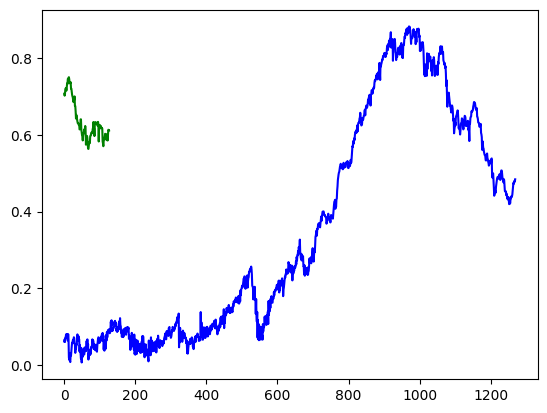

In [ ]:
# compare LSTM on trained on MSFT on predictions for Google
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(LSTM_MSFT_test, 'g')
ax.plot(LSTM_GOOG_yhat, 'b')
plt.show()




##4.3 Prophet Model



For this section is how we gonna fit the prophet model by using miscosoft company stock price data. The best hyperparameter we get by using the cross-validation

In [15]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import ParameterGrid

In [16]:
# Uploaded stock price csv
finance_data = pd.read_csv('/content/StockPrice-Hybrid-Model-/Finance Data/finance.csv')
finance_data.head()

,date,open,high,low,close,adj_close,volume,ticker,10mda,20mda,50mda,100mda,target,EWMA_20,EWMA_50,EWMA_100,rsi,MiddleBand,UpperBand,LowerBand
0,2017-08-04,72.400002,73.040001,72.239998,72.680000,67.571640,22579000,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-08-07,72.800003,72.900002,72.260002,72.400002,67.311348,18705700,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-08-08,72.089996,73.129997,71.750000,72.790001,67.673927,22044600,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-08-09,72.250000,72.510002,72.050003,72.470001,67.376427,22213400,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-08-10,71.900002,72.190002,71.349998,71.410004,66.390930,24734500,MSFT,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
MSFT_Data = finance_data[finance_data['ticker']=='MSFT']
Google_Data = finance_data[finance_data['ticker']=='GOOG']
# This function is used to get the train data and test data
def data_preparation(df):
  data=df[["date","adj_close"]]
  data = data.rename(columns = {'date':'ds', 'adj_close':'y'})
  return data


In [ ]:
# Define parameter grid to search over
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
}

# Initialize minimum error and best parameters
min_error = float('inf')
best_params = {}

# Loop through all parameter combinations
for params in ParameterGrid(param_grid):
    print('Testing parameters:', params)

    # Initialize Prophet model with specified hyperparameters
    model = Prophet(**params)
    model.fit(data_preparation(MSFT_Data))

    # Perform time series cross-validation
    df_cv = cross_validation(model=model, initial='1000 days', horizon='10 days', period='10 days')

    # Calculate performance metrics
    df_metrics = performance_metrics(df_cv)

    # Calculate mean cross-validation error
    mean_cv_error = df_metrics['mse'].mean()

    # Update minimum error and best parameters if new minimum is found
    if mean_cv_error < min_error:
        min_error = mean_cv_error
        best_params = params

# Print best hyperparameters and corresponding error
print('Best parameters:', best_params)
print('Minimum cross-validation error:', min_error)

### 4.3.1 Forecasting with Prophet

In [18]:
def get_data(df):
  Best_parameters={'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}
  # We use the best parameter to fit the model
  final_model = Prophet(**Best_parameters)
  final_model.fit(data_preparation(df))
  df = cross_validation(model=final_model, initial='124 days', horizon='10 days', period='10 days')
  return df

In [ ]:
MSFT_train_data = get_data(MSFT_Data)[['ds', 'yhat']]
MSFT_train_data.head()

In [ ]:
Google_train_data = get_data(Google_Data)[['ds', 'yhat']]
Google_train_data.head()

In [21]:
def prep_prophet(prophet_pred, data1):
  prophet_pred = prophet_pred.rename(columns = {'ds': 'date'}).set_index('date')
  main_data = data1.join(prophet_pred,how = 'left')
  returned = main_data.loc['2018-01-01':'2023-02-01', 'yhat']
  return returned

goog_data = prep_prophet(Google_train_data, frames[0])[10:]
msft_train_data = prep_prophet(MSFT_train_data, frames[1])[10:1153]
msft_test_data = prep_prophet(MSFT_train_data, frames[1])[1153:]


##4.4 Hybrid Model 

 ### 4.4.1 Define Training Data Using Ouputs from Standalone Models MSFT

In [23]:
#creating y_hybrid from y_train of the LSTM model
print(y_train.shape)
y_hybrid= y_train
print(y_train.shape, y_hybrid.shape)
print(goog_data.shape)

(1143, 1)
(1143, 1) (1143, 1)
(1270,)


In [40]:
#verifying that outputs from both the LSTM and Prohet models match in size
LSTM_MSFT_yhat = testmodel('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5', X_train)
print ("LSTM:", LSTM_MSFT_yhat.shape,"\n","Prophet:", msft_train_data.shape)

#merging the the outcomes from the LSTM model and the Prophet model

msft_hybrid = { 'LSTM':LSTM_MSFT_yhat.flatten(), 'prophet':np.array(msft_train_data), }
msft_hybrid_df = pd.DataFrame(msft_hybrid)

#scaling the MSFT_PROPHET column
scaler2 = MinMaxScaler()
msft_hybrid_df['prophet'] = scaler2.fit_transform(msft_hybrid_df[['prophet']])

#Defining the data for the hybrid training
X2_ft = np.array(msft_hybrid_df)
print("y_hybrid", y_hybrid.shape)

X_train2,y_train2 = lstm_split(msft_hybrid_df,y_hybrid,len(msft_hybrid_df))


36/36 [==============================] - 0s 4ms/step
LSTM: (1143, 1) 
 Prophet: (1143,)
y_hybrid (1143, 1)


In [ ]:
#LSTM Framework for the hybrid model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import Precision
from keras.optimizers import Adam
import keras_tuner


#Hybrid model architecture and training
LR = 0.01
EPOCH = 300
BATCH = 24
hybrid = Sequential()
hybrid.add(LSTM(units = 98, activation = "sigmoid", input_shape = (X_train2.shape[1], X_train2.shape[2]), return_sequences = False))
hybrid.add(Dropout(0.5))
hybrid.add(Dense(units =1))
hybrid.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ["mae"])
Early_stop = EarlyStopping(monitor='loss', min_delta=0, 
                           patience=25, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

hybrid_history = hybrid.fit(X_train2, y_train2, epochs = EPOCH, batch_size = BATCH, callbacks = [Early_stop])

hybrid_history.model.save('/content/StockPrice-Hybrid-Model-/Models/Hybrid_model1.h5')

###4.4.2 LOSS and MAE

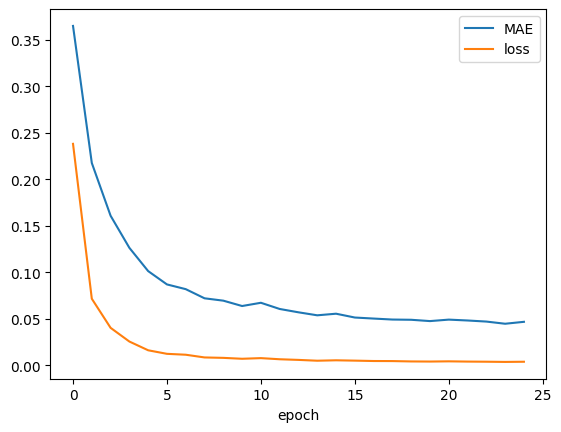

In [26]:
import matplotlib.pyplot as plt

# plot MAE and loss
#plt.figure(figsize=(10, 6))
plt.plot(hybrid_history.history['mae'], label='MAE')
plt.plot(hybrid_history.history['loss'], label='loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

### 4.4.3 Comparing output of LSTM MSFT and Hybrid MSFT 

###4.4.4 Hybrid Model Testing on GOOG

In [42]:
#merge lstm test prediction and prophet test prediction
def merge_predictions(lstm_pred,prophet_pred):
  data_dict = {}
  scaler = MinMaxScaler()
  data_dict['LSTM'] = lstm_pred.flatten()
  data_dict['prophet'] = np.array(prophet_pred)
  hybrid_test_data = pd.DataFrame(data_dict)
  hybrid_test_data['prophet'] = scaler.fit_transform(hybrid_test_data[['prophet']])
  return hybrid_test_data

In [43]:
from keras.models import load_model
MSFT_test_hybrid = merge_predictions(LSTM_MSFT_test, msft_test_data)
MSFT_x_test, MSFT_y_test = lstm_split(MSFT_test_hybrid, y_test, len(MSFT_test_hybrid))
MSFT_predictions = testmodel('/content/StockPrice-Hybrid-Model-/Models/Hybrid_model1.h5', MSFT_x_test)

4/4 [==============================] - 0s 7ms/step


In [44]:
print(LSTM_GOOG_yhat.shape,goog_data.shape)
GOOG_test_hybrid= merge_predictions(LSTM_GOOG_yhat, goog_data)
GOOG_x_test, GOOG_y_test = lstm_split(GOOG_test_hybrid,google_target,len(GOOG_test_hybrid))
GOOG_predictions = testmodel('/content/StockPrice-Hybrid-Model-/Models/Hybrid_model1.h5', GOOG_x_test)


(1270, 1) (1270,)
40/40 [==============================] - 0s 6ms/step


In [80]:
def compute_metrics(true_series, forecast):
    """Helper to print MSE and MAE"""
    mse = tf.keras.metrics.MeanSquaredError()
    mse.update_state(true_series, forecast)
    mae = tf.keras.metrics.MeanAbsoluteError()
    mae.update_state(true_series, forecast)
    print(f"the mean square error of the predictions is {mse.result().numpy()}, and the mean absolute error of the predictions is {mae.result().numpy()}")
    return mse.result().numpy(), mae.result().numpy()

In [73]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(msft_hybrid_df,y_hybrid)
linear_predictions_GOOG = linear_model.predict(GOOG_test_hybrid)
linear_predictions_MSFT = linear_model.predict(MSFT_test_hybrid)

###4.4.5 Predicted vs Actual Price

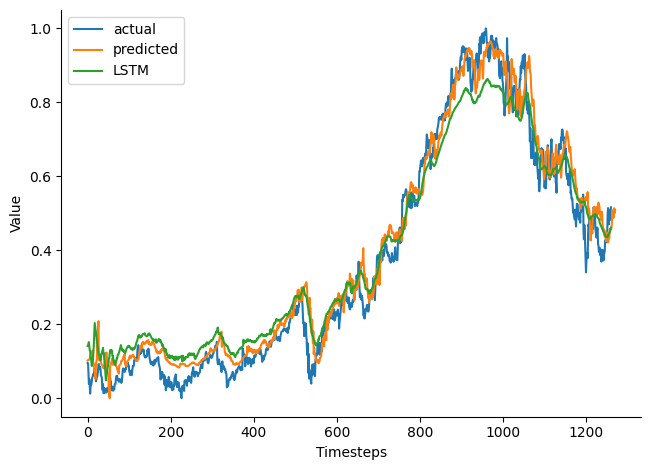

In [72]:

plt.plot(GOOG_y_test, label="True Values")
plt.plot(linear_predictions, label="Linear Hybrid")
plt.plot(GOOG_predictions, label="LSTM Hybrid")
plt.xlabel("Timesteps")
plt.ylabel("Value")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
x=np.arange(1,len(GOOG_y_test)+1, 1)
plt.plot(GOOG_predictions.flatten(), "r", label= "Hybrid")
plt.plot(LSTM_GOOG_yhat, "b", label= "LSTM")
plt.plot(GOOG_y_test, "g", label= "Actual")

plt.title(" Hybrid predictions vs LSTM predictions vs Actual predictions for Google")
plt.xlabel('X_test entry')
plt.legend()
plt.show()

## Return Predictions to Original Scale for Final Analysis

In [ ]:
GOOG_scaler = 
MSFT_scaler = 

#5.0 Multiple Company Model

## 5.1 Generate Sub-models

In [ ]:
def create_lists(list_of_df):
  training_list = []
  target_list = []
  for i in range(len(list_of_df)):
    scaler = MinMaxScaler()
    data = list_of_df[i]
    score = data['score']
    target = scaler.fit_transform(data[['target']])
    training = data.drop(['target', 'ticker', 'score'], axis = 1)
    for col in training.columns:
      training[col] = scaler.fit_transform(training[[col]])
    training['score'] = score
    data_x, data_y = lstm_split(training, target, len(training))
    training_list.append(data_x)
    target_list.append(data_y)
  return training_list, target_list

#General LSTM model based on randomsearch results
def multiple_models(x_train, y_train):
    hybrid = Sequential()
    hybrid.add(LSTM(units = 98, activation = "relu", input_shape = (x_train.shape[1], x_train.shape[2]), return_sequences = False))
    hybrid.add(Dropout(0.7))
    hybrid.add(Dense(units =1, activation = 'sigmoid'))
    hybrid.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ["mean_squared_error"])
    Early_stop = EarlyStopping(monitor='val_loss', min_delta=0, 
                              patience=25, verbose=1, mode='auto',
                              baseline=0, restore_best_weights=True)
    hybrid.fit(x_train, y_train, epochs = 200, batch_size = 24, callbacks = [Early_stop])
    return hybrid

training_list, target_list = create_lists(frames[1:])
for tick, x_train, y_train in zip(ticker_list, training_list, target_list):
  model = multiple_models(x_train, y_train)
  model.save('/content/StockPrice-Hybrid-Model-/sub_models/'+tick+'_lstm.h5')


### 5.1.1 Configure Hybrid Training Set and Train Hybrid Model

In [60]:
import os

def hybrid_train(direct, ticker_list, hybrid_train, prophet, targets):
    preds_dict = {}
    path = direct
    scaler = MinMaxScaler()
    for num, model in enumerate(os.listdir(path)):
        model = load_model(path+model)
        prediction = model.predict(hybrid_train).flatten()
        preds_dict[ticker_list[num]] = prediction
    preds_df = pd.DataFrame(preds_dict)
    preds_df['prophet'] = np.array(prophet)
    preds_df['prophet'] = scaler.fit_transform(preds_df[['prophet']])
    x1,y1 = lstm_split(preds_df, targets, len(preds_df))
    return x1, y1, preds_df, targets

ticker_list = ["MSFT", "NFLX", "AMZN", "TSLA"]
hybrid_training_data, targets, preds_df, training_y =  hybrid_train('/content/StockPrice-Hybrid-Model-/sub_models/', ticker_list, X_train, msft_train_data, y_hybrid) 
hybrid_expanded = multiple_models(hybrid_training_data, targets)

36/36 [==============================] - 0s 4ms/step
(1143, 1)
(1133, 1)
Epoch 1/200


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


44/48 [==========================>...] - ETA: 0s - loss: 0.0224 - mean_squared_error: 0.0224

48/48 [==============================] - 2s 10ms/step - loss: 0.0212 - mean_squared_error: 0.0212
Epoch 2/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

48/48 [==============================] - 0s 9ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 3/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

48/48 [==============================] - 0s 10ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 4/200
47/48 [============================>.] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

48/48 [==============================] - 0s 10ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 5/200
47/48 [============================>.] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

48/48 [==============================] - 0s 10ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 6/200
42/48 [=========================>....] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

48/48 [==============================] - 0s 9ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 7/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

48/48 [==============================] - 1s 10ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 8/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

48/48 [==============================] - 0s 10ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 9/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

48/48 [==============================] - 0s 10ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 10/200
48/48 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 11/200
48/48 [==============================] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

48/48 [==============================] - 0s 10ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 12/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 13/200
48/48 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 0s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 14/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 0s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 15/200
48/48 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

48/48 [==============================] - 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 16/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

48/48 [==============================] - 0s 10ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 17/200
48/48 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 1s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 18/200
48/48 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

48/48 [==============================] - 1s 14ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 19/200
47/48 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 1s 15ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 20/200
47/48 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 1s 15ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 21/200
47/48 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 1s 15ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 22/200
48/48 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 1s 15ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 23/200
47/48 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 1s 15ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 24/200
48/48 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

48/48 [==============================] - 1s 14ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 25/200
47/48 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

48/48 [==============================] - 0s 10ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 26/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 27/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 28/200
48/48 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 0s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 29/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 1s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 30/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 0s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 31/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 32/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 33/200
47/48 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 0s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 34/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 35/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 36/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 0s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 37/200
47/48 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

48/48 [==============================] - 0s 10ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 38/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 39/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 40/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 41/200
47/48 [============================>.] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 42/200
47/48 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 43/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 44/200
47/48 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 45/200
47/48 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 15ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 46/200
48/48 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 1s 15ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 47/200
48/48 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 1s 15ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 48/200
48/48 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 1s 15ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 49/200
47/48 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 15ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 50/200
48/48 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 15ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 51/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

48/48 [==============================] - 1s 15ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 52/200
47/48 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 53/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 54/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 55/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 56/200
48/48 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 57/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 58/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 59/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 60/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 61/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 62/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 63/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 64/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 65/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 66/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 67/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 68/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 69/200
48/48 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 70/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 71/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 72/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 14ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 73/200
48/48 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 1s 15ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 74/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 15ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 75/200
47/48 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 14ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 76/200
48/48 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 14ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 77/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

48/48 [==============================] - 1s 16ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 78/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 15ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 79/200
47/48 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 80/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 81/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 82/200
47/48 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 83/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 84/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 1s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 85/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 86/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 87/200
47/48 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 88/200
47/48 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 89/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 1s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 90/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 91/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 92/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 93/200
47/48 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 94/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 95/200
48/48 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 0s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 96/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 97/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 98/200
47/48 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 99/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 1s 14ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 100/200
48/48 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 14ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 101/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 14ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 102/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 14ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 103/200
48/48 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 15ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 104/200
47/48 [============================>.] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 15ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 105/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 1s 15ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 106/200
47/48 [============================>.] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 15ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 107/200
48/48 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 108/200
47/48 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 109/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 110/200
48/48 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 111/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 112/200
47/48 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 113/200
48/48 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 114/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 115/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 116/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 117/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 118/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 119/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 120/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 121/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 122/200
47/48 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 123/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 124/200
48/48 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 125/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

48/48 [==============================] - 0s 10ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 126/200
48/48 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 127/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 1s 15ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 128/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 1s 14ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 129/200
48/48 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 18ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 130/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 16ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 131/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 1s 14ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 132/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 14ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 133/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 17ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 134/200
47/48 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 135/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 136/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 137/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 138/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 139/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 140/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

48/48 [==============================] - 0s 10ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 141/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 142/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

48/48 [==============================] - 0s 10ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 143/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 0s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 144/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 0s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 145/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 146/200
47/48 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 147/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 0s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 148/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 149/200
48/48 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 150/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 151/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

48/48 [==============================] - 0s 10ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 152/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 1s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 153/200
47/48 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 154/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 16ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 155/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 15ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 156/200
48/48 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 14ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 157/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 14ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 158/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 15ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 159/200
47/48 [============================>.] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 1s 15ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 160/200
48/48 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 14ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 161/200
48/48 [==============================] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 1s 14ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 162/200
48/48 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 11ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 163/200
47/48 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 164/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 165/200
47/48 [============================>.] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 0s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 166/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

48/48 [==============================] - 1s 11ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 167/200
47/48 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 168/200
48/48 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 169/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 170/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 171/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 172/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

48/48 [==============================] - 1s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 173/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 174/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 175/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 176/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 177/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 178/200
47/48 [============================>.] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 11ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 179/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 180/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 181/200
48/48 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 12ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 182/200
48/48 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 15ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 183/200
48/48 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 15ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 184/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 14ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 185/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 14ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 186/200
47/48 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 16ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 187/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 16ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 188/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 17ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 189/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 190/200
47/48 [============================>.] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 0s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 191/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 192/200
48/48 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 193/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 194/200
48/48 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 195/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 196/200
48/48 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 11ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 197/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 198/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 0s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 199/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 200/200
47/48 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034


In [55]:
hybrid_expanded.save('/content/StockPrice-Hybrid-Model-/Models/hybrid_expanded.h5')

### 5.1.2 Test the Expanded Model

In [56]:
from os import listdir
hybrid_expanded = load_model('/content/StockPrice-Hybrid-Model-/Models/hybrid_expanded.h5')
google_test = {}
microsoft_test = {}
path = '/content/StockPrice-Hybrid-Model-/sub_models/'
for num, model in enumerate(os.listdir(path)):
  scaler = MinMaxScaler()
  model = load_model(path+model)
  goog_preds = model.predict(google_ft).flatten()
  micro_preds = model.predict(X_test).flatten()
  google_test[ticker_list[num]] = goog_preds
  microsoft_test[ticker_list[num]] = micro_preds
google_test = pd.DataFrame(google_test)
microsoft_test = pd.DataFrame(microsoft_test)

google_test['prophet'] = np.array(goog_data)
google_test['prophet'] = scaler.fit_transform(google_test[['prophet']])
microsoft_test['prophet'] = np.array(msft_test_data)
microsoft_test['prophet'] = scaler.fit_transform(microsoft_test[['prophet']])

goog_x, goog_y = lstm_split(google_test, google_target, len(google_test))
msft_x, msft_y = lstm_split(microsoft_test, y_test, len(microsoft_test))


4/4 [==============================] - 0s 5ms/step


In [74]:
goog_predictions = hybrid_expanded.predict(goog_x)
msft_predictions = hybrid_expanded.predict(msft_x)

4/4 [==============================] - 0s 6ms/step


In [75]:
linear_model = LinearRegression()
linear_model.fit(preds_df,training_y)
linear_ex_goog = linear_model.predict(google_test)
linear_ex_msft = linear_model.predict(microsoft_test)
mse, mae = compute_metrics(google_target, linear_predictions)
print(mse)

0.0015004585


In [76]:
mse, mae = compute_metrics(goog_y, goog_predictions)
print(mse)

0.0016877814


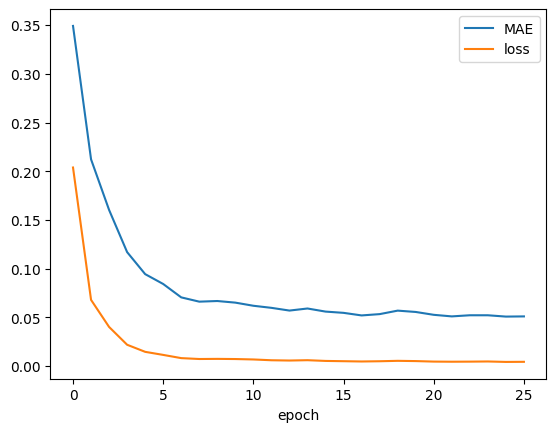

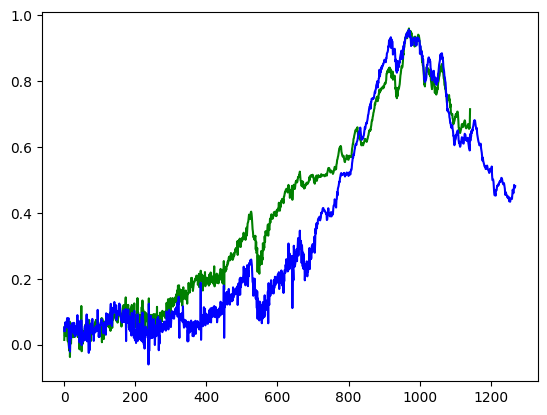

In [77]:
import matplotlib.pyplot as plt

# plot MAE and loss
#plt.figure(figsize=(10, 6))
plt.plot(hybrid_history.history['mae'], label='MAE')
plt.plot(hybrid_history.history['loss'], label='loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

# compare LSTM on trained on MSFT on predictions for Google
fig, ax = plt.subplots()
ax.plot(LSTM_MSFT_yhat, 'g')
ax.plot(LSTM_GOOG_yhat, 'b')
plt.show()

In [87]:
#prepare all predictions
#lstm
print('single LSTM model')
msft_lstm_mse, msft_lstm_mae = compute_metrics(y_test, LSTM_MSFT_test)
goog_lstm_mse, goog_lstm_mae = compute_metrics(google_scaler.inverse_transform(google_target), google_scaler.inverse_transform(LSTM_GOOG_yhat))

print('single hybrid model')
#single hybrid
msft_single_mse, msft_single_mae = compute_metrics(MSFT_y_test, MSFT_predictions)
goog_sinlge_mse, goog_single_mae = compute_metrics(google_scaler.inverse_transform(GOOG_y_test), google_scaler.inverse_transform(GOOG_predictions))

print('single linear model')
#Single linear hybrid
msft_sing_linear_mse, msft_sing_linear_mae = compute_metrics(y_test, linear_predictions_MSFT)
goog_linear_mse, goog_linear_mae = compute_metrics(google_scaler.inverse_transform(google_target), google_scaler.inverse_transform(linear_predictions_GOOG))

print('expanded hybrid model')
#expanded_hybrid
msft_expanded_mse, msft_expanded_mae = compute_metrics(msft_y, msft_predictions)
goog_expanded_mse, goog_expanded_mae = compute_metrics(goog_y, goog_predictions)

print('expanded linear model')
#Expanded linear hybrid
msft_exlin_mse, msft_exlin_mae = compute_metrics(y_test, linear_ex_msft)
goog_exlin_mse, goog_exlin_mae = compute_metrics(google_target, linear_ex_goog)

single LSTM model
the mean square error of the predictions is 0.0008603367023169994, and the mean absolute error of the predictions is 0.024465009570121765
the mean square error of the predictions is 12.430902481079102, and the mean absolute error of the predictions is 2.832007884979248
single hybrid model
the mean square error of the predictions is 0.022574296221137047, and the mean absolute error of the predictions is 0.12289301306009293
the mean square error of the predictions is 43.22639465332031, and the mean absolute error of the predictions is 5.691281318664551
single linear model
the mean square error of the predictions is 0.0020801268983632326, and the mean absolute error of the predictions is 0.03962451592087746
the mean square error of the predictions is 11.21248722076416, and the mean absolute error of the predictions is 2.476428508758545
expanded hybrid model
the mean square error of the predictions is 0.002956102602183819, and the mean absolute error of the predictions is